In [217]:
ls

2Autoencoder.ipynb      lens_2000_no_sc.h5        LSST_Mmxy.h5
generator_LSST.ipynb    lens_dataset_lsst_rgb.h5  VAE.ipynb
generator_LSST_mxyM.py  lensenv/                  VAE_LSST_2.ipynb
generator.py            lenstronomy-tutorials/    VAE_LSST_3.ipynb
lens_1000_no_sc.h5      LSST_EUCLID.ipynb         VAE_LSST.ipynb
lens_10k_no_sc.h5       LSST_generator.py


In [218]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F
from tqdm import trange


Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'source_x', 'source_y', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb shape: (1000, 40, 40, 3)
images_clean shape: (1000, 40, 40, 3)
delta_psi_maps shape: (1000, 40, 40)
subhalo_mass shape: (1000,)
subhalo_x shape: (1000,)
subhalo_y shape: (1000,)
Plotting samples: [601 439 577]


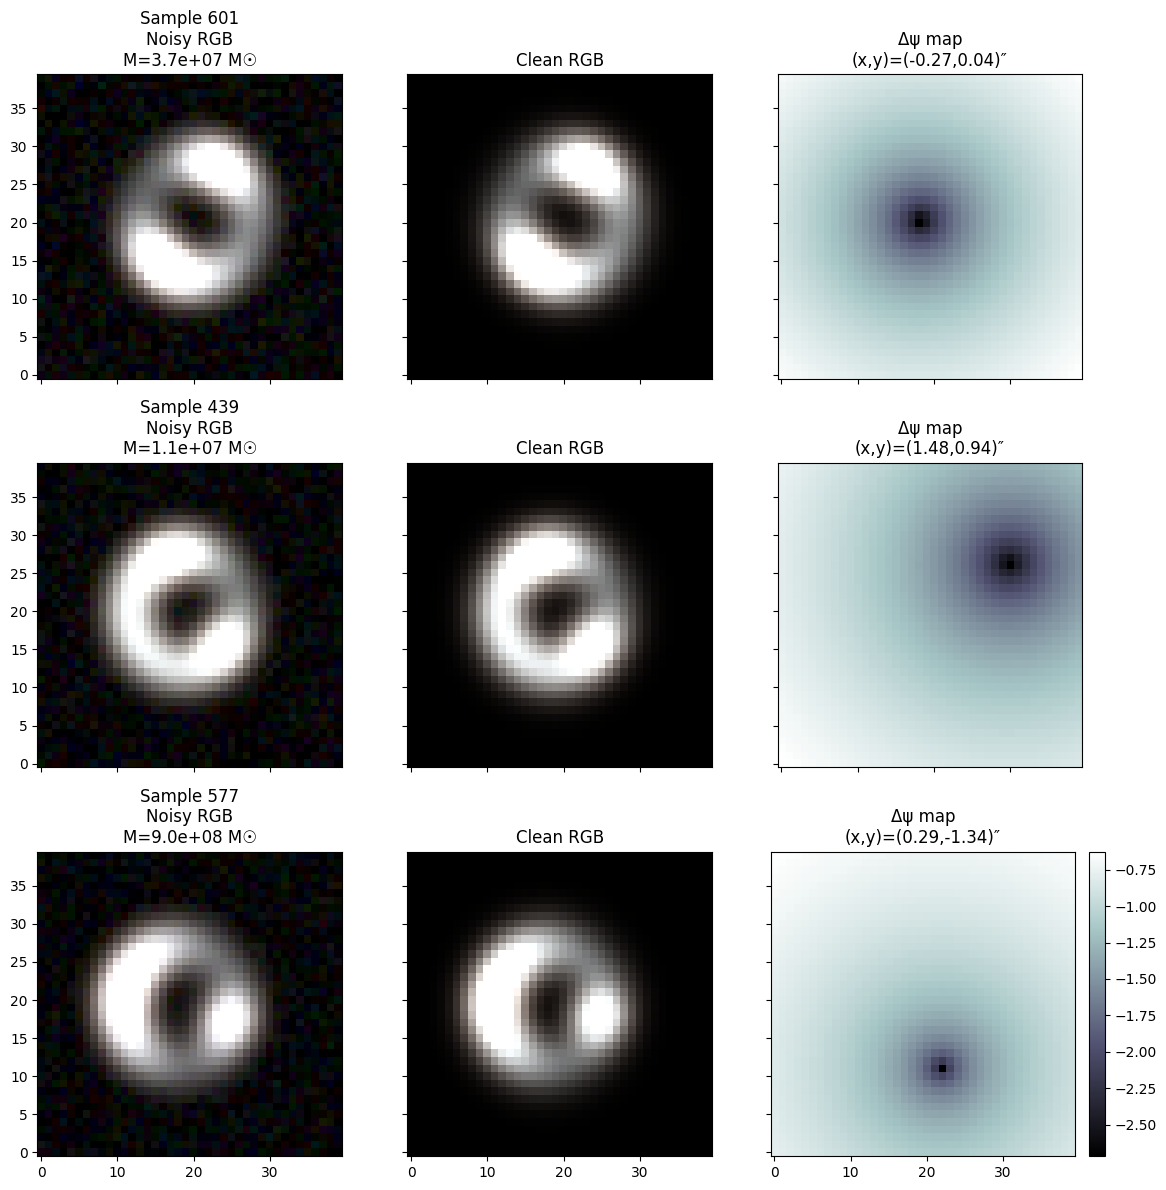

In [219]:
# Path to the new RGB HDF5 dataset
h5_path = 'LSST_Mmxy.h5'

with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_rgb shape:", f['images_rgb'].shape)
    print("images_clean shape:", f['images_clean'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_rgb'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for row, idx in enumerate(sample_indices):
        img_rgb     = f['images_rgb'][idx]    # shape (ny, nx, 3)
        img_clean   = f['images_clean'][idx]  # shape (ny, nx, 3)
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: RGB image with noise
        axes[row, 0].imshow(img_rgb, origin='lower')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy RGB\nM={mass:.1e} M☉")

        # Panel 2: RGB image clean (no subhalo, no noise)
        axes[row, 1].imshow(img_clean, origin='lower')
        axes[row, 1].set_title("Clean RGB")

        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='bone')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Colorbar only for Δψ on the last row
        if row == 2:
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [220]:
# 1) Load the data from the HDF5 file
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_rgb'][:]    # (N, H, W, 3)
    Y_smooth = f['images_clean'][:]   # (N, H, W, 3)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W, 3)
    sub_mass = f['subhalo_mass'][:]  # (N,)
    sub_x    = f['subhalo_x'][:]     # (N,)
    sub_y    = f['subhalo_y'][:]     # (N,)

### Step 2: Pre-processing

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.




In [221]:
# 2) Clean the data (mismo que antes)
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)
sub_mass = np.nan_to_num(sub_mass, nan=0.0, posinf=None, neginf=None)
sub_x    = np.nan_to_num(sub_x,    nan=0.0, posinf=None, neginf=None)
sub_y    = np.nan_to_num(sub_y,    nan=0.0, posinf=None, neginf=None)

# 3) Convertir a tensores en formato channel-first
# X_noisy: (N, H, W, 3) -> (N, 3, H, W)
X  = torch.from_numpy(X_noisy).permute(0, 3, 1, 2).float()

# Y_smooth: si también es RGB (N, H, W, 3) -> (N, 3, H, W)
Y1 = torch.from_numpy(Y_smooth).permute(0, 3, 1, 2).float()

# Y_delta: 1 canal (N, H, W) -> (N, 1, H, W)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)


In [222]:
#Split the data into training, validation, and test sets
# 1) Índices para cada subconjunto
idx = np.arange(X.shape[0])

# 10% para test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)

# De lo que queda (90%), separar 20% para validación → equivale a 2/9 ≈ 22.22%
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

# 2) Split de imágenes
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

# 3) Split de masa y coordenadas
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]

In [223]:
#Visualización de los datos
def describe_tensor(t, name):
    print(f"--- {name} ---")
    print("Shape:", t.shape)
    print("Min:", t.min().item())
    print("Max:", t.max().item())
    print("Mean:", t.mean().item())
    print("Std:", t.std().item())
    print("Median:", t.median().item())
    print("Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]:", np.percentile(t.cpu().numpy().flatten(), [0.1, 1, 25, 50, 75, 99, 99.9]))
    print()

describe_tensor(X_train, "X_train (Noisy RGB)")
describe_tensor(Y1_train, "Y1_train (Clean RGB)")
describe_tensor(Y2_train, "Y2_train (Δψ)")


--- X_train (Noisy RGB) ---
Shape: torch.Size([700, 3, 40, 40])
Min: 0.0
Max: 1.0
Mean: 0.18989591300487518
Std: 0.2938995659351349
Median: 0.05435173586010933
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [0.         0.         0.         0.05435175 0.21588078 1.
 1.        ]

--- Y1_train (Clean RGB) ---
Shape: torch.Size([700, 3, 40, 40])
Min: 2.7153814752267635e-09
Max: 1.0
Mean: 0.17395368218421936
Std: 0.30058008432388306
Median: 0.00498468242585659
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [1.33021268e-08 7.95992079e-08 1.20461906e-04 4.98472410e-03
 2.09252521e-01 1.00000000e+00 1.00000000e+00]

--- Y2_train (Δψ) ---
Shape: torch.Size([700, 1, 40, 40])
Min: -2.992327928543091
Max: -0.5485213994979858
Mean: -1.440330982208252
Std: 0.36678799986839294
Median: -1.4324402809143066
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [-2.67515161 -2.34700015 -1.69711989 -1.43243992 -1.15581876 -0.75053825
 -0.65614407]



Text(0.5, 1.0, 'Distribución: Y2_train (Δψ)')

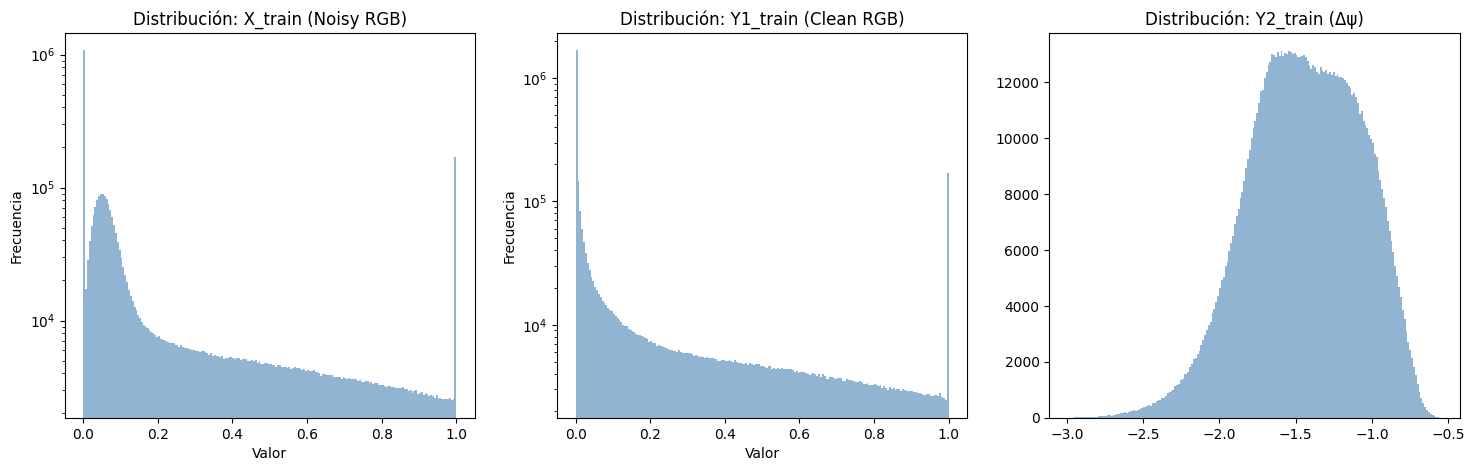

In [224]:
#Histograma de las variables
def plot_histogram(tensor, title, bins=200):
    t_np = tensor.cpu().numpy().flatten()
    plt.hist(t_np, bins=bins, alpha=0.6, color='steelblue')
    plt.title(title)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

# plot_histogram(X_train, "Distribución: X_train (Noisy RGB)")
# plot_histogram(Y1_train, "Distribución: Y1_train (Clean RGB)")
# plot_histogram(Y2_train, "Distribución: Y2_train (Δψ)")

#Ponemos lo anterior en un subplot para los tres histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(X_train.cpu().numpy().flatten(), bins=200, alpha=0.6, color='steelblue')
axes[0].set_title("Distribución: X_train (Noisy RGB)")
axes[0].set_xlabel("Valor")
#ponemos escala logarítmica en el eje y
axes[0].set_yscale('log')
axes[0].set_ylabel("Frecuencia")
axes[1].hist(Y1_train.cpu().numpy().flatten(), bins=200, alpha=0.6, color='steelblue')
axes[1].set_title("Distribución: Y1_train (Clean RGB)")
axes[1].set_yscale('log')
axes[1].set_xlabel("Valor")
axes[1].set_ylabel("Frecuencia")
axes[2].hist(Y2_train.cpu().numpy().flatten(), bins=200, alpha  = 0.6, color='steelblue')
axes[2].set_title("Distribución: Y2_train (Δψ)")                


In [225]:
mean_Y2 = Y2_train.mean().item()
std_Y2 = Y2_train.std().item()

Y2_train = (Y2_train - mean_Y2) / std_Y2
Y2_val   = (Y2_val   - mean_Y2) / std_Y2
Y2_test  = (Y2_test  - mean_Y2) / std_Y2

# --- Asegurar conversión a tensores ---
sub_mass_train = torch.tensor(sub_mass_train).float()
sub_mass_val   = torch.tensor(sub_mass_val).float()
sub_mass_test  = torch.tensor(sub_mass_test).float()

sub_x_train = torch.tensor(sub_x_train).float()
sub_x_val   = torch.tensor(sub_x_val).float()
sub_x_test  = torch.tensor(sub_x_test).float()


sub_y_train = torch.tensor(sub_y_train).float()
sub_y_val   = torch.tensor(sub_y_val).float()
sub_y_test  = torch.tensor(sub_y_test).float()

# --- Agrupar y normalizar ---
mxy_train = torch.stack([sub_mass_train, sub_x_train, sub_y_train], dim=1)
mxy_val   = torch.stack([sub_mass_val,   sub_x_val,   sub_y_val],   dim=1)
mxy_test  = torch.stack([sub_mass_test,  sub_x_test,  sub_y_test],  dim=1)

mean_mxy = mxy_train.mean(dim=0)
std_mxy  = mxy_train.std(dim=0)

mxy_train = (mxy_train - mean_mxy) / std_mxy
mxy_val   = (mxy_val   - mean_mxy) / std_mxy
mxy_test  = (mxy_test  - mean_mxy) / std_mxy


Text(0.5, 1.0, 'Distribución de coordenadas y')

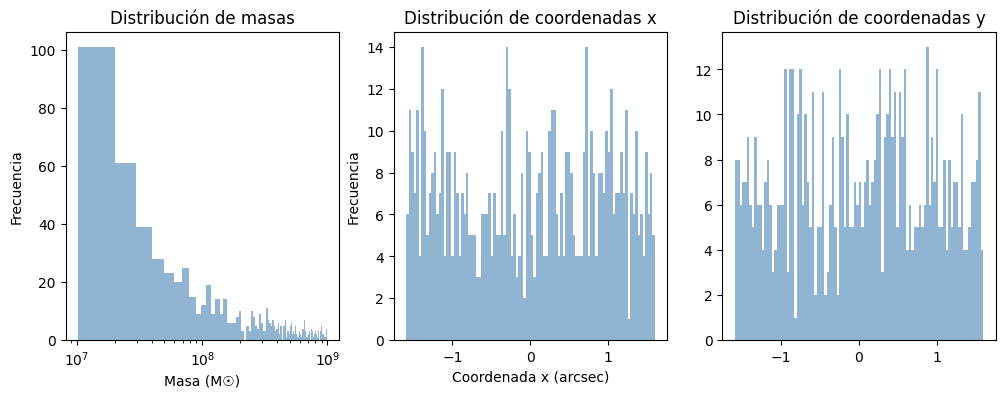

In [226]:
#Vamos a visualizar la distribución de las masas y coordenadas
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(sub_mass_train.cpu().numpy(), bins=100, alpha=0.6, color='steelblue')
plt.title("Distribución de masas")
plt.xlabel("Masa (M☉)")
plt.xscale('log')
plt.ylabel("Frecuencia")
plt.subplot(1, 3, 2)
plt.hist(sub_x_train.cpu().numpy(), bins=100, alpha=0.6,    color='steelblue') 

#Ahora ponemos en un subplot m, x, y
plt.title("Distribución de coordenadas x")
plt.xlabel("Coordenada x (arcsec)")
plt.ylabel("Frecuencia")
plt.subplot(1, 3, 3)
plt.hist(sub_y_train.cpu().numpy(), bins=100, alpha=0.6, color='steelblue')
plt.title("Distribución de coordenadas y")          

In [227]:
# ✅ Estadísticas que sí necesitas guardar:
# 1. Para desnormalizar Y2 (Δψ map):

# Como estás usando z-score:
# mean_Y2 = Y2_train.mean().item()
# std_Y2 = Y2_train.std().item()

# 2. Para desnormalizar mxy (masa, x, y):
# mean_mxy = mxy_train.mean(dim=0)  # tensor([mean_mass, mean_x, mean_y])
# std_mxy = mxy_train.std(dim=0)    # tensor([std_mass, std_x, std_y])

norm_stats = {
    "mean_Y2": mean_Y2,
    "std_Y2": std_Y2,
    "mean_mass": mean_mxy[0].item(),
    "std_mass":  std_mxy[0].item(),
    "mean_x":    mean_mxy[1].item(),
    "std_x":     std_mxy[1].item(),
    "mean_y":    mean_mxy[2].item(),
    "std_y":     std_mxy[2].item()
}


### Normalization

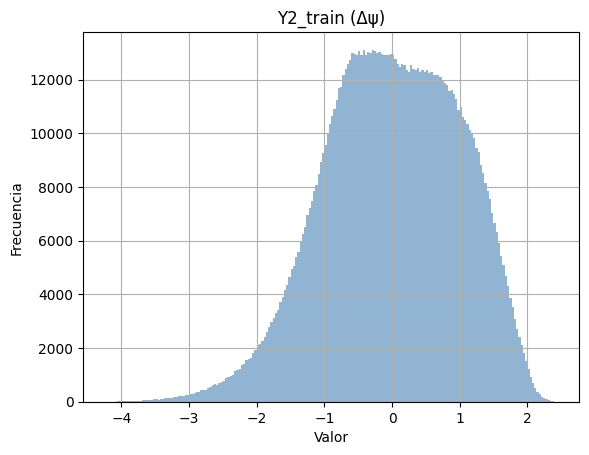

In [228]:
plot_histogram(Y2_train, "Y2_train (Δψ)")


### 📦 7) Dataset and DataLoader

This section prepares the datasets and data loaders used during training, validation, and testing.

---

#### 🔹 1) Create TensorDatasets

We package the input and target tensors into `TensorDataset` objects. This allows us to efficiently iterate through the data during training and evaluation.

```python
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val, mxy_val)


In [229]:
from torch.utils.data import TensorDataset, DataLoader
import torch
#un batch más grande implica más memoria, pero puede ayudar a la estabilidad del entrenamiento
#uno mas chico implica más ruido en el gradiente, pero menos memoria

batch = 128  # Tamaño del batch
on_cuda = torch.cuda.is_available()

# 1) Datasets
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val,   mxy_val)
test_ds  = TensorDataset(X_test,  Y1_test,  Y2_test,  mxy_test)

# 2) DataLoaders
common_kwargs = dict(
    batch_size=batch,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

train_loader = DataLoader(
    train_ds,
    shuffle=True,
    drop_last=True,
    **common_kwargs
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)

test_loader = DataLoader(
    test_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)


In [230]:
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_ds, shuffle=True, generator=g, drop_last=True, **common_kwargs)

In [231]:
# Device
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


🧠 DualVAE: Variational Autoencoder with Physical Regression

This model is a **Variational Autoencoder (VAE)** designed to process gravitational lensing data. It performs:

- **Dual reconstruction**:
  - A smooth background light source.
  - A lensing potential perturbation map (ΔΨ).
- **Regression of physical parameters**:
  - Subhalo **mass**, **x-position**, and **y-position**.

---

#### 🔹 Encoder

The encoder consists of **3 convolutional layers** with:
- 3×3 kernel, stride 2, padding 1 (downsampling by 8× total),
- ReLU activations,
- Dropout for regularization (`p=0.3`).

These layers transform the input image into a feature map, which is then flattened and projected into the latent space using two linear layers:
- `fc_mu` → mean vector `μ` (for latent variable)
- `fc_logvar` → log variance `logσ²`

---

#### 🔹 Latent Space & Sampling

To enable backpropagation through stochastic sampling, the model uses the **reparameterization trick**:

```python
z = mu + eps * std

self.fc_regs = nn.Sequential(
    nn.Linear(z_dim, z_dim // 2),
    nn.Tanh(),
    nn.Dropout(0.1),
    nn.Linear(z_dim // 2, 3)
)


In [232]:
class DualVAE(nn.Module):
    def __init__(self, in_ch=3, base_ch=16, z_dim=256, H=40, W=40):
        super().__init__()

        # ——— Encoder (3 convs stride=2) → (H/8, W/8) = (5,5) si H=W=40
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(), nn.Dropout(0.2),
        )

        # Tamaños tras las 3 convs (para 40→20→10→5)
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)   # 20
        H2, W2 = conv_out(H1),   conv_out(W1)  # 10
        H3, W3 = conv_out(H2),   conv_out(W2)  # 5

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ——— VAE stats
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——— z → feature map
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # Decoder para imagen suave (RGB)
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),  # (N, 4*ch, 5, 5)
            nn.ConvTranspose2d(self._C3,   self._C3//2, 4, 2, 1),  # 5→10
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(self._C3//2, base_ch,    4, 2, 1),  # 10→20
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(base_ch,     3,          4, 2, 1),  # 20→40
            #nn.Sigmoid()
        )

        # Decoder para Δψ
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),  # (N, 4*ch, 5, 5)
            nn.ConvTranspose2d(self._C3,   self._C3//2, 4, 2, 1),  # 5→10
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(self._C3//2, base_ch,    4, 2, 1),  # 10→20
            nn.ReLU(), nn.Dropout(0.2),
            nn.ConvTranspose2d(base_ch,     1,          4, 2, 1)   # 20→40
        )

        # ——— Cabezal de regresión (m, x, y) desde μ
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim//2),
            nn.Tanh(), nn.Dropout(0.2),
            nn.Linear(z_dim//2, z_dim//2),
            nn.Tanh(), nn.Dropout(0.2),
            nn.Linear(z_dim//2, 3)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)  # (N, 3, 40, 40)
        d = self.decoder_d(h)  # (N, 1, 40, 40)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        mxy_pred = self.fc_regs(mu)  # (N, 3)
        return s, d, mu, logvar, mxy_pred


In [233]:
model = DualVAE(in_ch=3, base_ch=20, z_dim=256, H=40, W=40).to(device)


In [234]:
# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,  # learning rate
    weight_decay=1e-4
)

In [235]:
##### otra versión del costo ######
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    """
    Combined loss for multitask VAE.
    """
    # Reconstruction loss (RGB + alpha * Δψ)
    recon_rgb = F.mse_loss(s_pred, s_true)
    recon_d   = F.mse_loss(d_pred, d_true)
    recon = recon_rgb + alpha * recon_d

    # KL divergence (average over batch * z_dim)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Regression loss
    reg = F.mse_loss(mxy_pred, mxy_true)

    # Final loss
    total = recon + beta * kl + gamma * reg

    return total


In [236]:
def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2):
    model.train()
    running_loss = 0.0

    for i, (x, y_s, y_d, mxy) in enumerate(loader):
        x   = x.to(device, non_blocking=True)
        y_s = y_s.to(device, non_blocking=True)
        y_d = y_d.to(device, non_blocking=True)
        mxy = mxy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # ❌ sin autocast
        p_s, p_d, mu, logvar, mxy_pred = model(x)

        recon_s = F.mse_loss(p_s, y_s)
        recon_d = F.mse_loss(p_d, y_d)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        reg = F.mse_loss(mxy_pred, mxy)

        loss = recon_s + alpha * recon_d + beta * kl + gamma * reg

        # ❌ sin scaler
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        if i < log_batches:
            print(f"[Batch {i}] Loss: {loss.item():.4f} | Recon_s: {recon_s.item():.4f} | "
                  f"Recon_d: {recon_d.item():.4f} | KL: {kl.item():.4f} | Reg: {reg.item():.4f}")

    return running_loss / len(loader.dataset)


def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x   = x.to(device, non_blocking=True)
            y_s = y_s.to(device, non_blocking=True)
            y_d = y_d.to(device, non_blocking=True)
            mxy = mxy.to(device, non_blocking=True)

            # ❌ sin autocast
            p_s, p_d, mu, logvar, mxy_pred = model(x)

            loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                 alpha, beta, gamma)

            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


In [237]:
# # Diagnóstico previo al entrenamiento
# model.eval()
# with torch.no_grad():
#     x, y_s, y_d, mxy = next(iter(train_loader))
#     x = x.to(device)
#     y_s, y_d = y_s.to(device), y_d.to(device)

#     s_pred, d_pred, *_ = model(x)

#     print(f"s_pred: min={s_pred.min().item():.4f}, max={s_pred.max().item():.4f}")
#     print(f"d_pred: min={d_pred.min().item():.4f}, max={d_pred.max().item():.4f}")
#     print(f"y_s:    min={y_s.min().item():.4f}, max={y_s.max().item():.4f}")
#     print(f"y_d:    min={y_d.min().item():.4f}, max={y_d.max().item():.4f}")


In [238]:

# Training loop
num_epochs = 500
alpha = 1.0 # peso de la reconstrucción de la imagen suave 
beta  = 1e-3 # peso de la divergencia KL
gamma = 1.0 # peso de la regresión de masa y coordenadas

train_losses = []
val_losses   = []

outer_bar = trange(5, num_epochs + 1, desc="Epoch", ncols=120, colour="#00E1FF", dynamic_ncols=False)

for epoch in outer_bar:
    train_loss = train_epoch(train_loader, optimizer, alpha, beta, gamma, log_batches=0)  # 👈 no imprimir batches
    val_loss   = eval_epoch(val_loader, alpha, beta, gamma)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")


Epoch: 100%|████████████████████████████████████████████████| 496/496 [01:19<00:00,  6.28it/s, train=0.9059, val=1.5070]


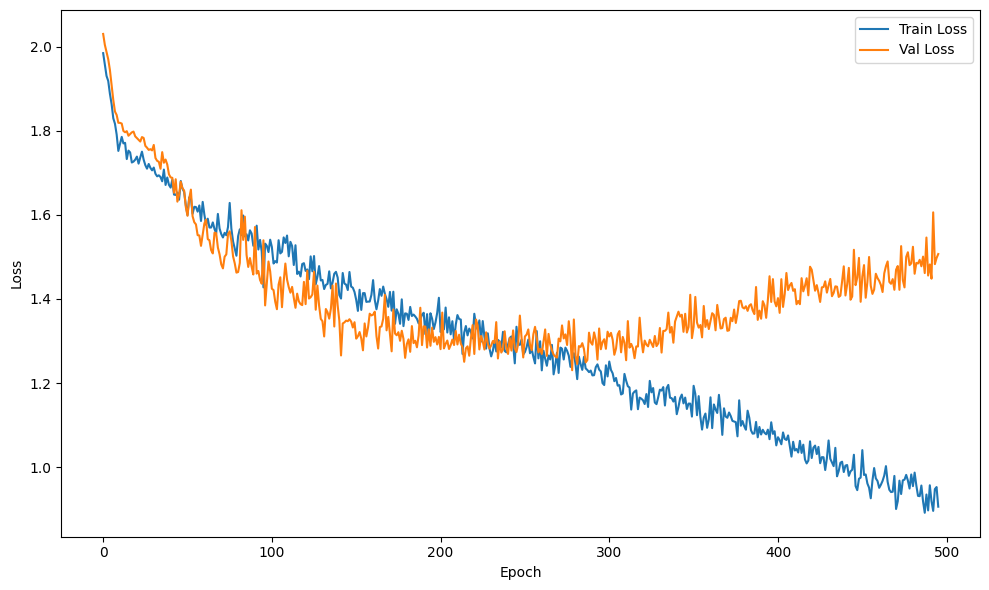

In [239]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
#plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


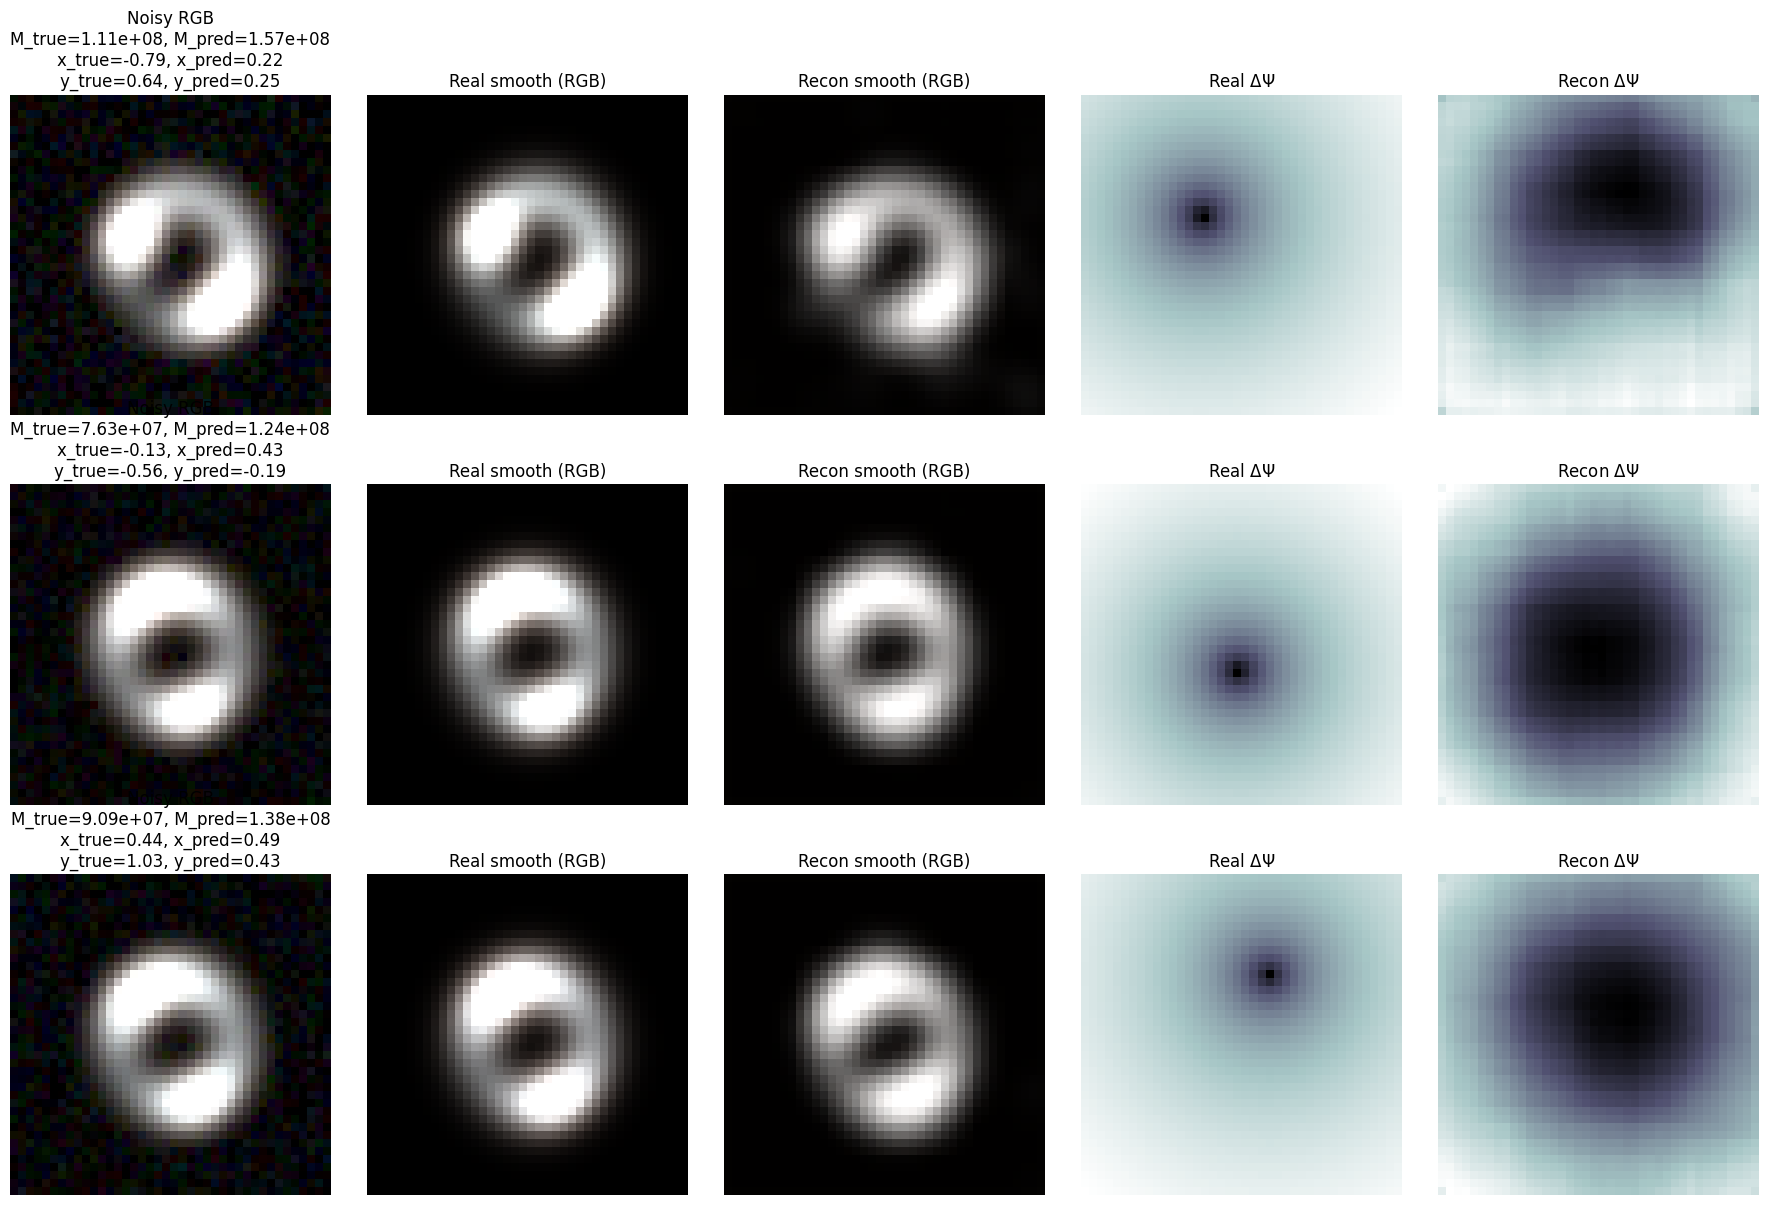

In [240]:
# === Paso 1: Forward pass y conversión a NumPy ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# Convertir a NumPy (todo en CPU)
x_np         = x.detach().cpu().numpy()
y_true_s_np  = y_true_smooth.detach().cpu().numpy()
y_true_d_np  = y_true_delta.detach().cpu().numpy()
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()
mxy_true_np  = mxy_true.detach().cpu().numpy()
mxy_pred_np  = mxy_pred.detach().cpu().numpy()

# === Paso 2: Desnormalización ===
mean_Y2 = norm_stats["mean_Y2"]
std_Y2  = norm_stats["std_Y2"]

mean_mxy = np.array([norm_stats["mean_mass"], norm_stats["mean_x"], norm_stats["mean_y"]])
std_mxy  = np.array([norm_stats["std_mass"],  norm_stats["std_x"],  norm_stats["std_y"]])

# Desnormalizar predicciones y ground truth
mxy_pred_np_denorm = mxy_pred_np * std_mxy + mean_mxy
mxy_true_np_denorm = mxy_true_np * std_mxy + mean_mxy
y_pred_d_np_denorm = y_pred_d_np * std_Y2 + mean_Y2
y_true_d_np_denorm = y_true_d_np * std_Y2 + mean_Y2

# === Paso 3: Visualización ===
offset    = 0
max_rows  = 3
N         = x_np.shape[0]
n_samples = max(1, min(max_rows, N - offset))

fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4 * n_samples))
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Valores de regresión desnormalizados
    m_true, x_true, y_true = mxy_true_np_denorm[idx]
    m_pred, x_pred, y_pred = mxy_pred_np_denorm[idx]

    # Col 0: Entrada ruidosa
    ax = axes[i, 0]
    ax.imshow(np.clip(x_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2e}, M_pred={m_pred:.2e}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real (RGB)
    ax = axes[i, 1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # Col 2: Smooth recon (RGB)
    ax = axes[i, 2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # Col 3: Δψ real
    ax = axes[i, 3]
    ax.imshow(y_true_d_np_denorm[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon
    ax = axes[i, 4]
    ax.imshow(y_pred_d_np_denorm[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


MASS  MSE=3.0461e+16, MAE=1.2568e+08,  R²=0.5050
XPOS  MSE=8.5692e-01, MAE=7.8858e-01,  R²=-0.1718
YPOS  MSE=1.0070e+00, MAE=8.3372e-01,  R²=-0.2020


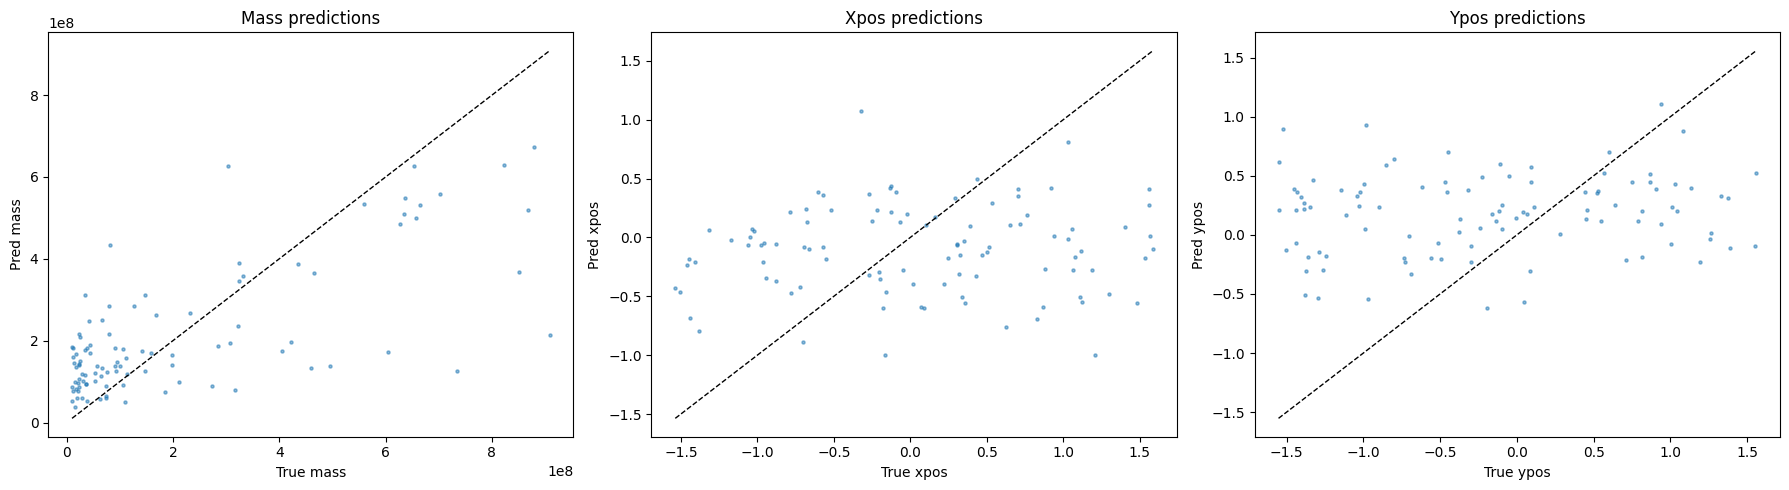

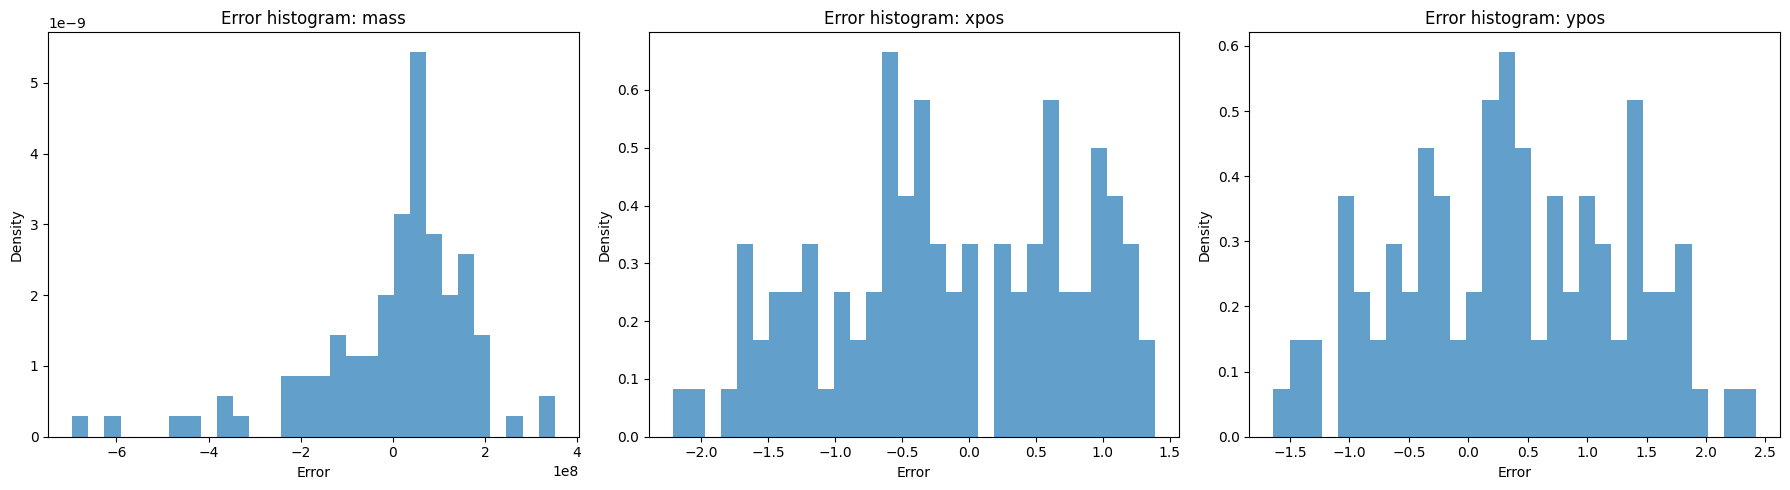

In [241]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Extrae medias y stds para desnormalizar
mean_mxy = np.array([
    norm_stats["mean_mass"],
    norm_stats["mean_x"],
    norm_stats["mean_y"]
])
std_mxy = np.array([
    norm_stats["std_mass"],
    norm_stats["std_x"],
    norm_stats["std_y"]
])

# 2) Eval loop
model.eval()
all_pred = []
all_true = []

with torch.no_grad():
    for x, y_s, y_d, mxy_true in test_loader:
        x = x.to(device)
        _, _, _, _, mxy_pred = model(x)
        all_pred.append(mxy_pred.cpu().numpy())
        all_true.append(mxy_true.numpy())

# 3) Concatenar resultados
all_pred = np.vstack(all_pred)  # shape (N, 3)
all_true = np.vstack(all_true)

# 4) Desnormalizar
all_pred = all_pred * std_mxy + mean_mxy
all_true = all_true * std_mxy + mean_mxy

# 5) Métricas por variable
names = ['mass', 'xpos', 'ypos']
for i, name in enumerate(names):
    y_t = all_true[:, i]
    y_p = all_pred[:, i]
    mse = mean_squared_error(y_t, y_p)
    mae = mean_absolute_error(y_t, y_p)
    r2  = r2_score(y_t, y_p)
    print(f"{name.upper():>4}  MSE={mse:.4e}, MAE={mae:.4e},  R²={r2:.4f}")

# 6) Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, name in enumerate(names):
    axes[i].scatter(all_true[:, i], all_pred[:, i], s=5, alpha=0.5)
    min_val = min(all_true[:, i].min(), all_pred[:, i].min())
    max_val = max(all_true[:, i].max(), all_pred[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    axes[i].set_xlabel(f"True {name}")
    axes[i].set_ylabel(f"Pred {name}")
    axes[i].set_title(f"{name.title()} predictions")
plt.tight_layout()
plt.show()

# 7) Histogramas de error
errors = all_pred - all_true
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, name in enumerate(names):
    axes[i].hist(errors[:, i], bins=30, density=True, alpha=0.7)
    axes[i].set_title(f"Error histogram: {name}")
    axes[i].set_xlabel("Error")
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()


In [242]:
# import h5py

# h5_path = 'LSST_Mmxy.h5'

with h5py.File(h5_path, 'r') as f:
    # Mostrar los datasets disponibles y sus dimensiones
    print("Datasets disponibles:")
    for key in f.keys():
        print(f"  {key}: shape = {f[key].shape}")

    # Mostrar las primeras 5 muestras de cada campo relevante
    print("\nPrimeras 5 muestras de parámetros:")
    for param in ['subhalo_mass', 'subhalo_x', 'subhalo_y', 'source_x', 'source_y']:
        print(f"{param}: {f[param][:5]}")


Datasets disponibles:
  delta_psi_maps: shape = (1000, 40, 40)
  images_clean: shape = (1000, 40, 40, 3)
  images_rgb: shape = (1000, 40, 40, 3)
  source_x: shape = (1000,)
  source_y: shape = (1000,)
  subhalo_mass: shape = (1000,)
  subhalo_x: shape = (1000,)
  subhalo_y: shape = (1000,)

Primeras 5 muestras de parámetros:
subhalo_mass: [8.0101338e+08 6.5859661e+08 1.3343671e+08 3.3484589e+08 1.1191512e+08]
subhalo_x: [-0.5545026  -0.79323715  1.2965355   0.9406121  -0.9222269 ]
subhalo_y: [ 0.5770247   1.324866    0.17096645 -1.5618942   0.8801246 ]
source_x: [-0.10508984 -0.02275915  0.0778058   0.07495129  0.06972726]
source_y: [-0.18284422  0.12300678 -0.00086002  0.2324709  -0.11584999]


In [243]:
#vamos a ver el rango de valores de las coordenadas
with h5py.File(h5_path, 'r') as f:
    sub_x = f['subhalo_x'][:]
    sub_y = f['subhalo_y'][:]
    print("Rango de coordenadas x:", sub_x.min(), "a", sub_x.max())
    print("Rango de coordenadas y:", sub_y.min(), "a", sub_y.max())
    print("Rango de masas:", f['subhalo_mass'][:].min(), "a", f['subhalo_mass'][:].max())   

Rango de coordenadas x: -1.5908166 a 1.5979432
Rango de coordenadas y: -1.5958703 a 1.5922692
Rango de masas: 10106866.0 a 998552640.0
